# Plant Disease Classification with Plant Village Dataset


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

In [10]:
# Define data directories
data_dir = "/kaggle/input/plantvillage-dataset/color"

In [11]:
# define data transformations including augmentation for train, validation, and test sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),  
        transforms.RandomRotation(40),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3), value=0, inplace=False),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


image_dataset = datasets.ImageFolder(root=data_dir)  
class_names = image_dataset.classes
num_classes = len(class_names)

# Split the dataset into train, validation, and test sets
train_size = int(0.8 * len(image_dataset))
val_size = int(0.1 * len(image_dataset))
test_size = len(image_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(image_dataset, [train_size, val_size, test_size])
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']
test_dataset.dataset.transform = data_transforms['test']

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)


print(len(train_dataset), len(val_dataset), len(test_dataset))

43444 5430 5431


In [12]:
# Load a pre-trained ResNet model
model = models.resnet50(pretrained=True)

# Modify the last fully connected layer to match the number of classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)


# Define loss function and optimizer
criterion_1 = nn.CrossEntropyLoss()
criterion_2 = nn.MultiMarginLoss()

optimizer_1 = optim.Adam(model.parameters(), lr=0.0001)
optimizer_2 = optim.SGD(model.parameters(), lr=0.0001, momentum=0.8)


scheduler_1 = lr_scheduler.StepLR(optimizer_1, step_size=7, gamma=0.1)
scheduler_2 = lr_scheduler.StepLR(optimizer_2, step_size=7, gamma=0.1)

In [13]:
# Define the device to train on (CPU/GPU if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model= nn.DataParallel(model)
# Move the model to the device
model = model.to(device)

print(device)

cuda:0


In [ ]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, test_loader, num_epochs=50, patience=5):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_loss = float('inf')
    no_improvement = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_train_loss = 0.0
        running_corrects = 0
        total_batches = len(train_loader)

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            progress = (batch_idx + 1) / total_batches * 100
            print(f'Epoch [{epoch + 1}/{num_epochs}] Training... {progress:.2f}% complete', end='\r')

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        epoch_train_acc = running_corrects.double() / len(train_loader.dataset)
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        running_corrects = 0

        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == labels.data)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_acc = running_corrects.double() / len(val_loader.dataset)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        print(f'Epoch [{epoch + 1}/{num_epochs}] '
              f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, '
              f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}')

        # Early stopping check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= patience:
            print(f'Early stopping! No improvement for {patience} epochs.')
            break

        scheduler.step()

    return history

# Choose criterion and optimizer for training
selected_criterion = criterion_1
selected_optimizer = optimizer_1
selected_scheduler = scheduler_1


In [15]:
# Train the model
history = train_model(model, selected_criterion, selected_optimizer, selected_scheduler, train_loader, val_loader, test_loader, num_epochs=50, patience=5)

Epoch [1/50] Train Loss: 0.2591, Train Acc: 0.9294, Val Loss: 0.0604, Val Acc: 0.9823
Epoch [2/50] Train Loss: 0.0909, Train Acc: 0.9713, Val Loss: 0.0393, Val Acc: 0.9880
Epoch [3/50] Train Loss: 0.0642, Train Acc: 0.9804, Val Loss: 0.0388, Val Acc: 0.9873
Epoch [4/50] Train Loss: 0.0523, Train Acc: 0.9833, Val Loss: 0.0250, Val Acc: 0.9926
Epoch [5/50] Train Loss: 0.0420, Train Acc: 0.9859, Val Loss: 0.0409, Val Acc: 0.9878
Epoch [6/50] Train Loss: 0.0387, Train Acc: 0.9881, Val Loss: 0.0443, Val Acc: 0.9867
Epoch [7/50] Train Loss: 0.0299, Train Acc: 0.9905, Val Loss: 0.0324, Val Acc: 0.9919
Epoch [8/50] Train Loss: 0.0086, Train Acc: 0.9980, Val Loss: 0.0083, Val Acc: 0.9976
Epoch [9/50] Train Loss: 0.0039, Train Acc: 0.9991, Val Loss: 0.0070, Val Acc: 0.9976
Epoch [10/50] Train Loss: 0.0028, Train Acc: 0.9994, Val Loss: 0.0083, Val Acc: 0.9972
Epoch [11/50] Train Loss: 0.0022, Train Acc: 0.9994, Val Loss: 0.0055, Val Acc: 0.9980
Epoch [12/50] Train Loss: 0.0018, Train Acc: 0.9997,

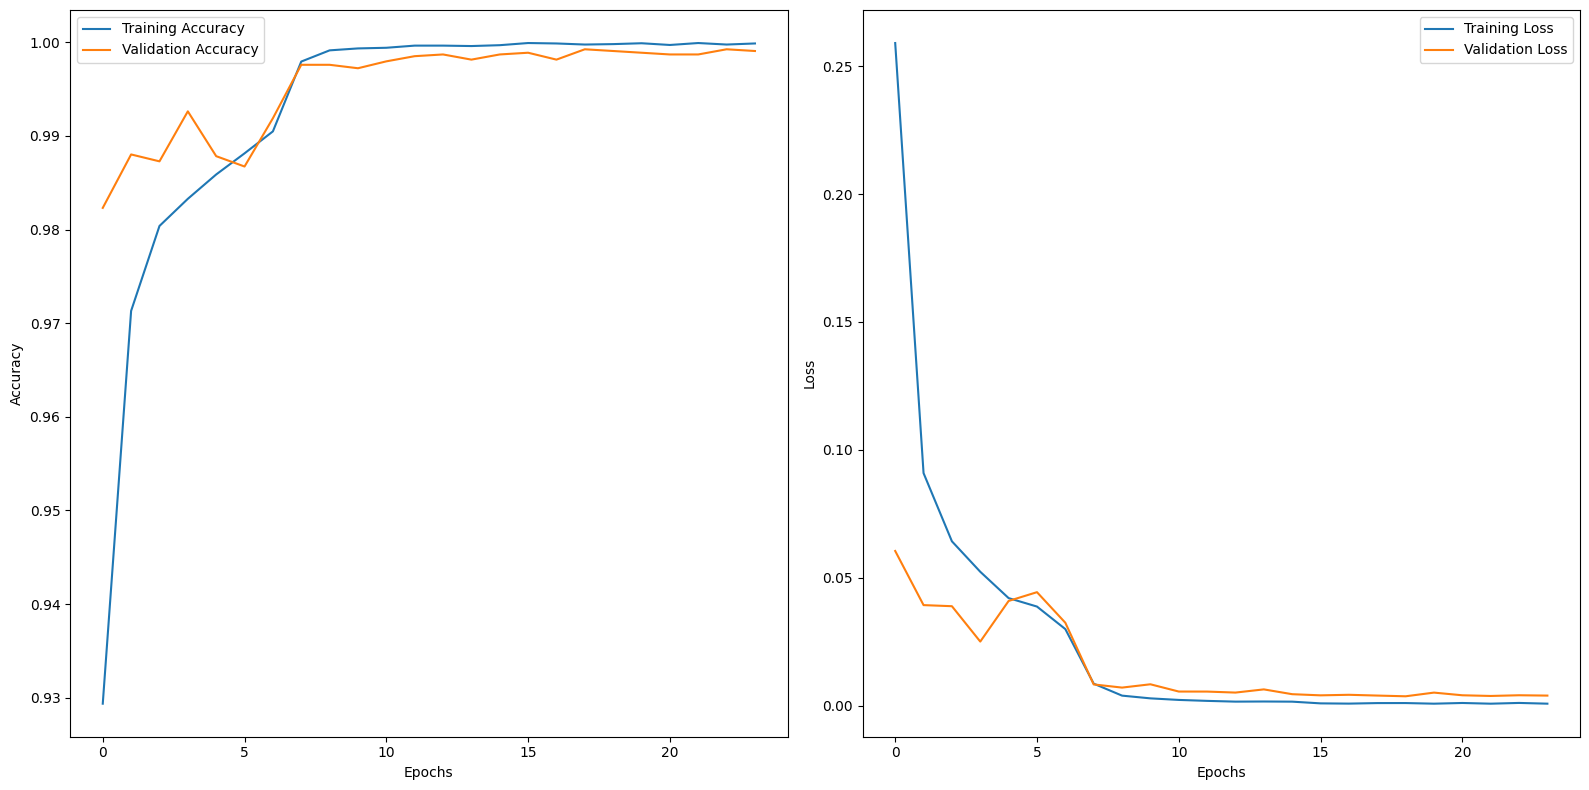

In [16]:
# Move tensors from GPU to CPU for plotting
train_acc_cpu = [acc.item() for acc in history['train_acc']]
val_acc_cpu = [acc.item() for acc in history['val_acc']]

# Plotting the training history with a larger size
plt.figure(figsize=(16, 8))  

plt.subplot(1, 2, 1)
plt.plot(train_acc_cpu, label='Training Accuracy')
plt.plot(val_acc_cpu, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [17]:
# Evaluation
model.eval()
running_corrects = 0

for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    running_corrects += torch.sum(preds == labels.data)

dataset_size = len(test_dataset)
accuracy = running_corrects.double() / dataset_size
print('Test Accuracy: {:.4f}'.format(accuracy))

Test Accuracy: 0.9969


In [18]:
def predict_labels(model, test_loader):
    model.eval()
    predicted_labels = []
    true_labels = []

    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        predicted_labels.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

    return true_labels, predicted_labels

# Using the function to get predicted and true labels
true_labels, predicted_labels = predict_labels(model, test_loader)

# Convert predicted and true labels to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Create a classification report
report = classification_report(true_labels, predicted_labels)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        66
           1       1.00      1.00      1.00        55
           2       1.00      1.00      1.00        30
           3       1.00      1.00      1.00       170
           4       1.00      1.00      1.00       159
           5       1.00      1.00      1.00       118
           6       1.00      1.00      1.00        93
           7       0.98      0.93      0.95        54
           8       0.99      1.00      0.99        98
           9       0.96      0.98      0.97        96
          10       1.00      1.00      1.00        98
          11       1.00      0.99      1.00       116
          12       0.99      1.00      1.00       147
          13       1.00      1.00      1.00        95
          14       1.00      1.00      1.00        40
          15       1.00      1.00      1.00       557
          16       1.00      1.00      1.00       220
          17       0.98    